       ONU   T-CONT  Assigned Bandwidth (Mbps)  Latency (ms)  \
0    ONU_1  T-CONT1                  88.000000      0.079266   
1    ONU_1  T-CONT2                  42.030729      0.079266   
2    ONU_1  T-CONT3                  13.392285      0.079266   
3    ONU_1  T-CONT4                   4.267195      0.079266   
4    ONU_2  T-CONT1                  70.000000      0.134607   
5    ONU_2  T-CONT2                  38.209753      0.134607   
6    ONU_2  T-CONT3                  12.174805      0.134607   
7    ONU_2  T-CONT4                   3.879268      0.134607   
8    ONU_3  T-CONT1                  60.000000      0.126462   
9    ONU_3  T-CONT2                  34.736140      0.126462   
10   ONU_3  T-CONT3                  11.068005      0.126462   
11   ONU_3  T-CONT4                   3.526607      0.126462   
12   ONU_4  T-CONT1                  89.000000      0.098305   
13   ONU_4  T-CONT2                  31.578309      0.098305   
14   ONU_4  T-CONT3                  10.

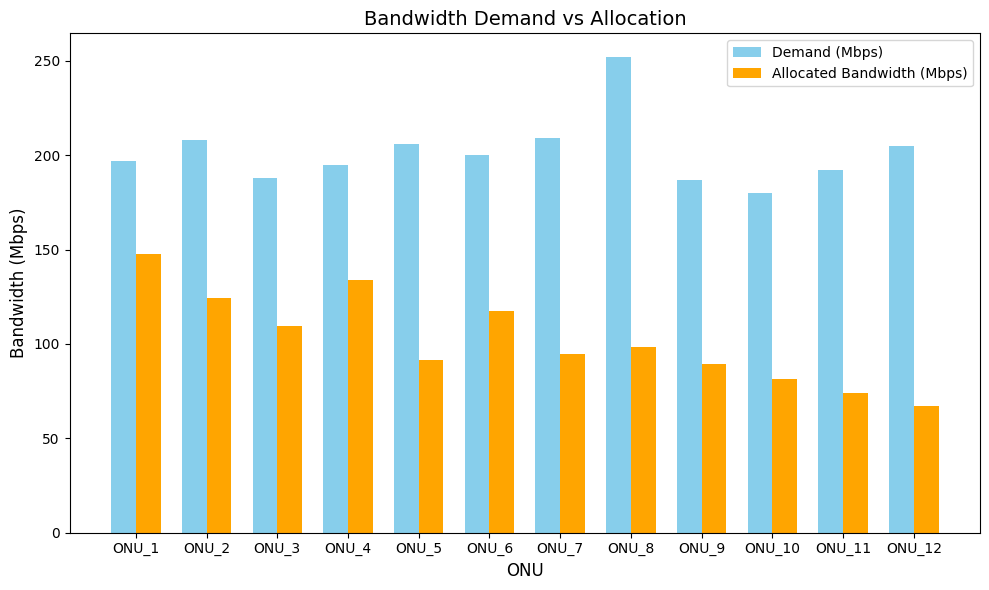

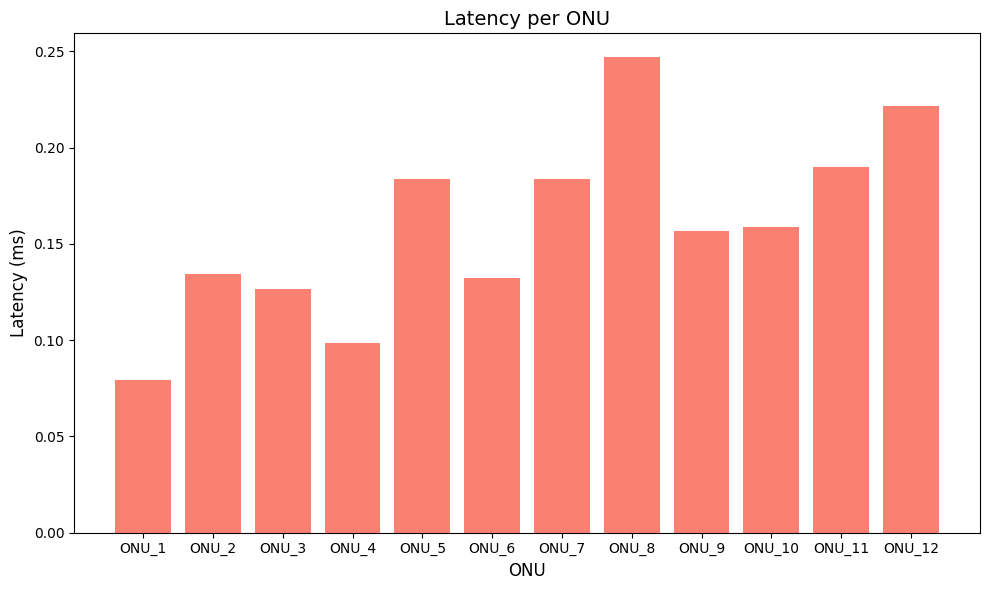

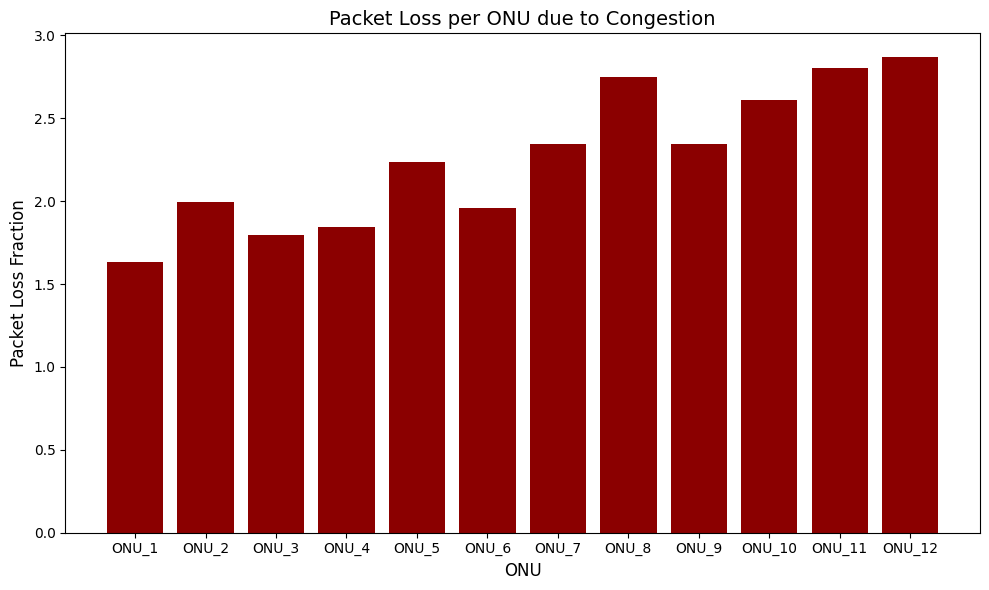

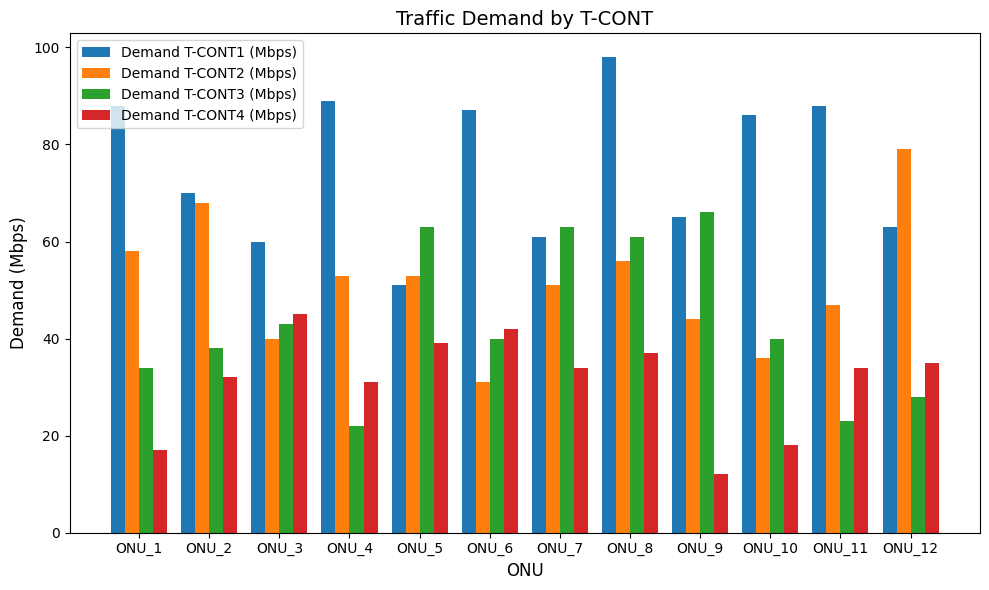

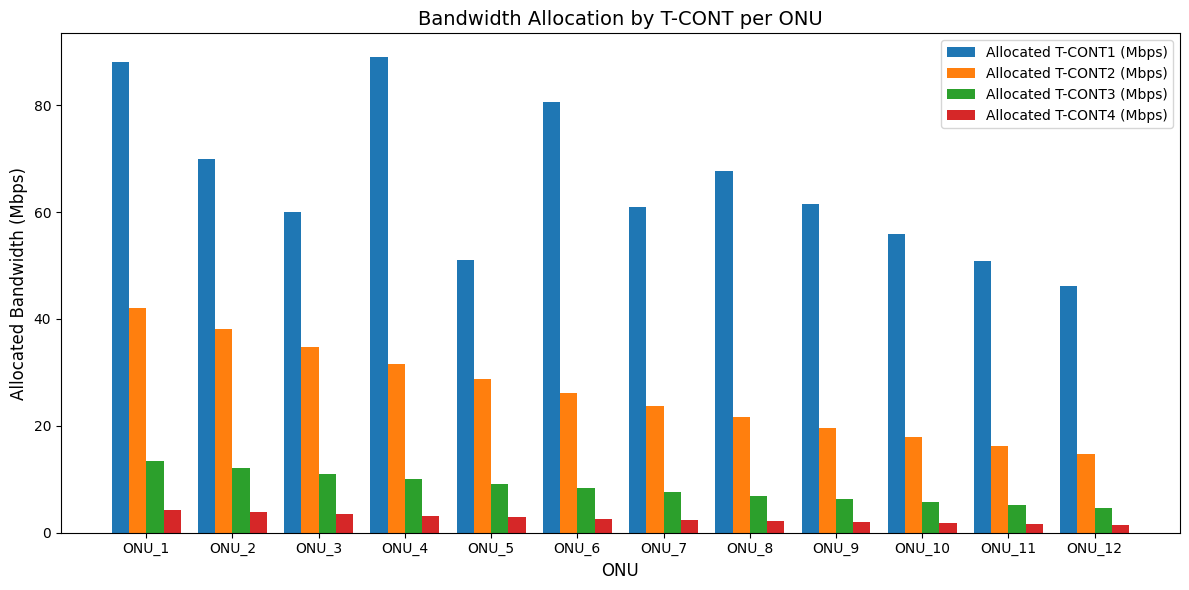

In [12]:
import numpy as np
import pandas as pd

NUM_ONUs = 12  # Número de ONUs
OLT_BANDWIDTH = 1244.16  # Mbps (capacidad total de GPON)
CYCLE_TIME = 2  # ms (tiempo de ciclo de sondeo)
CONGESTION_THRESHOLD = 0.8  # Umbral de congestión (80% de la capacidad máxima de OLT)

# Demandas de tráfico por ONU y T-CONT (en Mbps)
np.random.seed(42)
traffic_demands = {
    f"ONU_{i+1}": {
        "T-CONT1": np.random.randint(50, 100),  # Alta prioridad
        "T-CONT2": np.random.randint(30, 80),  # Garantizado
        "T-CONT3": np.random.randint(20, 70),  # Best-effort
        "T-CONT4": np.random.randint(10, 50),  # No garantizado
    }
    for i in range(NUM_ONUs)
}

# Función para calcular asignación de ancho de banda y latencias
def dynamic_bandwidth_allocation(demands, bandwidth, cycle_time):
    # Inicializar resultados
    allocations = {}
    latencies = {}
    packet_losses = {}
    remaining_bandwidth = bandwidth  # Ancho de banda disponible

    # Asignación de T-CONTs por prioridad
    for priority in ["T-CONT1", "T-CONT2", "T-CONT3", "T-CONT4"]:
        for onu, demand in demands.items():
            if onu not in allocations:
                allocations[onu] = {tcont: 0 for tcont in demand}  # Inicializar asignación por T-CONT
                latencies[onu] = 0
                packet_losses[onu] = 0

            # Asignar ancho de banda según demanda y disponibilidad
            allocation = min(demand[priority], remaining_bandwidth / (NUM_ONUs - list(allocations.keys()).count(onu)))
            allocations[onu][priority] += allocation
            remaining_bandwidth -= allocation

            # Calcular latencia como el tiempo de espera en el ciclo
            latencies[onu] += (demand[priority] - allocation) / bandwidth * cycle_time

            # Calcular pérdida de paquetes basada en congestión
            if demand[priority] > allocation:
                packet_loss = (demand[priority] - allocation) / demand[priority]
                packet_losses[onu] += packet_loss

    return allocations, latencies, packet_losses

# Realizar la asignación y calcular las pérdidas de paquetes
allocations, latencies, packet_losses = dynamic_bandwidth_allocation(traffic_demands, OLT_BANDWIDTH, CYCLE_TIME)

# Mostrar resultados
allocations_df = pd.DataFrame([(onu, tcont, allocation) for onu, tcont_alloc in allocations.items() for tcont, allocation in tcont_alloc.items()], columns=["ONU", "T-CONT", "Assigned Bandwidth (Mbps)"])
latencies_df = pd.DataFrame(latencies.items(), columns=["ONU", "Latency (ms)"])
packet_losses_df = pd.DataFrame(packet_losses.items(), columns=["ONU", "Packet Loss Fraction"])

results_df = pd.merge(allocations_df, latencies_df, on="ONU")
results_df = pd.merge(results_df, packet_losses_df, on="ONU")

print(results_df)

import matplotlib.pyplot as plt

# Crear gráficos
def plot_bandwidth_allocation(demands, allocations):
    # Gráfico de asignación de ancho de banda
    onu_labels = list(demands.keys())
    demand_totals = [sum(demands[onu].values()) for onu in onu_labels]
    allocation_totals = [sum(allocations[onu].values()) for onu in onu_labels]

    x = np.arange(len(onu_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, demand_totals, width, label='Demand (Mbps)', color='skyblue')
    ax.bar(x + width/2, allocation_totals, width, label='Allocated Bandwidth (Mbps)', color='orange')

    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Bandwidth (Mbps)', fontsize=12)
    ax.set_title('Bandwidth Demand vs Allocation', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(onu_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_latencies(latencies):
    # Gráfico de latencias
    onu_labels = list(latencies.keys())
    latency_values = list(latencies.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(onu_labels, latency_values, color='salmon')
    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.set_title('Latency per ONU', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_packet_loss(packet_losses):
    # Gráfico de pérdida de paquetes
    onu_labels = list(packet_losses.keys())
    packet_loss_values = list(packet_losses.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(onu_labels, packet_loss_values, color='darkred')
    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Packet Loss Fraction', fontsize=12)
    ax.set_title('Packet Loss per ONU due to Congestion', fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_traffic_demands(demands):
    # Gráfico de demanda por T-CONT
    onu_labels = list(demands.keys())
    tconts = list(next(iter(demands.values())).keys())

    demand_matrix = np.array([[demands[onu][tcont] for tcont in tconts] for onu in onu_labels])

    x = np.arange(len(onu_labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, tcont in enumerate(tconts):
        ax.bar(x + i*width - (len(tconts)-1)*width/2, demand_matrix[:, i], width, label=f'Demand {tcont} (Mbps)')

    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Demand (Mbps)', fontsize=12)
    ax.set_title('Traffic Demand by T-CONT', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(onu_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_bandwidth_allocation_by_tcont(allocations):
    # Gráfico de asignación de ancho de banda por T-CONT
    onu_labels = list(allocations.keys())
    tconts = list(allocations[onu_labels[0]].keys())  # Tomar los T-CONTs de cualquier ONU

    # Crear una matriz de asignaciones
    allocation_matrix = np.array([[allocations[onu][tcont] for tcont in tconts] for onu in onu_labels])

    x = np.arange(len(onu_labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, tcont in enumerate(tconts):
        ax.bar(x + i*width - (len(tconts)-1)*width/2, allocation_matrix[:, i], width, label=f'Allocated {tcont} (Mbps)')

    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Allocated Bandwidth (Mbps)', fontsize=12)
    ax.set_title('Bandwidth Allocation by T-CONT per ONU', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(onu_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()


# Generar gráficos
plot_bandwidth_allocation(traffic_demands, allocations)
plot_latencies(latencies)
plot_packet_loss(packet_losses)
plot_traffic_demands(traffic_demands)
plot_bandwidth_allocation_by_tcont(allocations)
